In [1]:
import numpy as np
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict
import random
import wordcloud

from urllib.request import urlopen
import scipy.optimize
import nltk
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.collocations import *

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## Load Dataset
Dataset comes from this link: https://nijianmo.github.io/amazon/index.html

In [3]:
data = getDF(r'Industrial_and_Scientific_5.json.gz')

In [4]:
data.shape

(77071, 12)

### Clean Data

In [5]:
rname = {'reviewerID': 'user_id', 
         'asin': 'product_id', 
         'overall': 'rating'}
temp = data[['reviewerID','asin', 'overall', 'reviewTime', 'unixReviewTime', 'reviewText']]
ratings = temp.rename(columns=rname)
ratings[['year', 'month']] = pd.DataFrame([[int(dt[-4:]), int(dt[:2])] for dt in ratings['reviewTime']]) 
ratings['YYYYMM'] = [datetime.utcfromtimestamp(ts).strftime('%Y%m') for ts in ratings['unixReviewTime']]
ratings.head()

,user_id,product_id,rating,reviewTime,unixReviewTime,reviewText,year,month,YYYYMM
0,A1JB7HFWHRYHT7,B0000223SI,5.0,"11 27, 2017",1511740800,This worked really well for what I used it for...,2017,11,201711
1,A2FCLJG5GV8SD6,B0000223SI,5.0,"11 4, 2017",1509753600,Fast cutting and good adheasive.,2017,11,201711
2,A3IT9B33NWYQSL,B0000223SI,5.0,"10 27, 2017",1509062400,Worked great for my lapping bench. I would li...,2017,10,201710
3,AUL5LCV4TT73P,B0000223SK,4.0,"01 13, 2018",1515801600,As advertised,2018,1,201801
4,A1V3I3L5JKO7TM,B0000223SK,5.0,"10 7, 2017",1507334400,seems like a pretty good value as opposed to b...,2017,10,201710


## 1. Exploratory Data Analysis

#### (1) Distribution histogram over rating

In [6]:
temp = ratings['rating'].value_counts().sort_index()

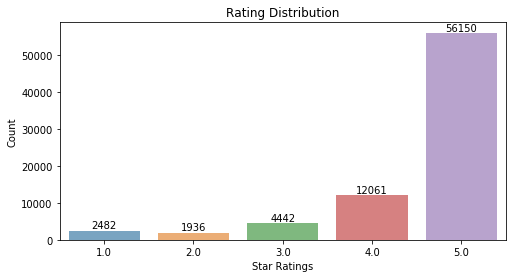

In [7]:
plt.figure(figsize=(8,4))
ax = sns.barplot(temp.index, temp.values, alpha=0.65)
plt.title("Rating Distribution")
plt.ylabel('Count')
plt.xlabel('Star Ratings')
for rect, label in zip(ax.patches, temp.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### (2) Seasonality

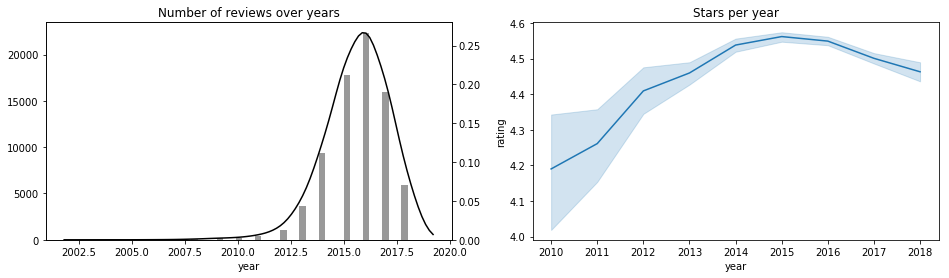

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
sns.distplot(ratings.year, hist=True, kde=False, color='k', ax=axes[0])
sns.distplot(ratings.year, hist=False, color='k', ax=axes[0].twinx(),
             kde_kws={'bw':0.4})
sns.lineplot(x='year', y='rating', data=ratings[ratings['year']>=2010], ax=axes[1])
axes[0].set_title('Number of reviews over years')
axes[1].set_title('Stars per year')
plt.show()

From the distribution of 

Most ratings are really high, the dataset is unbalanced. 

Consider a similar situation, fraud email. We can see both situations as classification problem. Machine learning really excels at identifying fraudlent activities. Similarly, it should be also good at predicting ratings with unbalanced data.

Find the rating less than 3 can be considered as negative. Challenge: build a model to predict whether a review is positive or negative. Used to recommend products to a user based on the predicted rating this user might give. If predict positive, recommend.

###  Number of reviews over month w/ average rating line

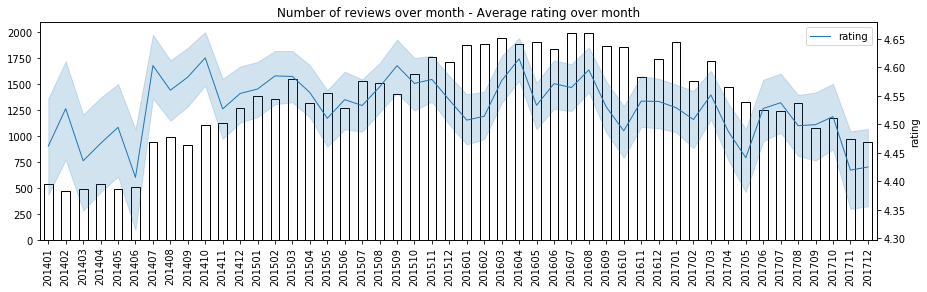

In [9]:
temp = pd.Series([item[0] for item in ratings[['YYYYMM', 'year']].values if item[1] >= 2014 and item[1] < 2018]).value_counts().sort_index() 
fig, ax = plt.subplots(figsize=(15,4))
#sns.distplot(ratings.YYYYMM, hist=True, kde=False, ax=ax)
temp.plot.bar(ax=ax, color='w', edgecolor='k', label='count')
sns.lineplot(x='YYYYMM', y='rating', data=ratings[(ratings['year'] >= 2014) & (ratings['year'] < 2018)], 
             linewidth=1.0, ax=ax.twinx(), dashes=True, label='rating')
plt.title('Number of reviews over month - Average rating over month')
plt.legend(loc='best')
plt.show()

From the distribution of number of reviews over years, notice that most reviews fall into 2014-2017. That's reasonable because this dataset is collected in 2018. Therefore, it would be good to focus on this time period. After plotting the number of reviews over month, as well as the average rating over month, it's clear that most ratings are above 4 stars, which aligns with the rating distribution.

- Here comes the question of interests: In the context of recommender system, we would like to recommend one with products that are probably able to get "good" ratings. Since most ratings are above 4 stars, it's reasonable to denote positive reviews as those with rating greater than 4 stars, and negative otherwise. 

- Then, the challenge is to predict whether a user will give positive review to one product or not.

- Model Evaluation: For unbalanced data, Balanced Error Rate (BER) is a suitable measurement.

- Baseline: To make comparison with well constructed machine learning model, it would be better to chose a baseline model. In the context of recommender system, one simple is average rating of user, product or general. 

## 2. Baseline Model: Latent-Factor Model
Recommender System

### Shuffle data to ensure randomness (re-run the following cell will impact on other results)

In [10]:
df = ratings.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

,user_id,product_id,rating,reviewTime,unixReviewTime,reviewText,year,month,YYYYMM
0,A34OSFN13ID8RR,B000HBOYZO,4.0,"07 5, 2017",1499212800,Worked as designed. Used this to connect rang...,2017,7,201707
1,AIKBGWIANH7ZQ,B019WTZK7M,5.0,"01 23, 2017",1485129600,"A reasonably priced, great quality toolless cl...",2017,1,201701
2,A34OSFN13ID8RR,B008YA6BWE,4.0,"01 11, 2018",1515628800,Works as designed!,2018,1,201801
3,AUMTCRN8IXPST,B000ILJZN4,5.0,"02 14, 2016",1455408000,I bought this polyethylene sheet to make runne...,2016,2,201602
4,A323VAGKTBE006,B000VBGG42,5.0,"08 29, 2016",1472428800,LOVE IT,2016,8,201608


### df is the shuffled dataframe.

In [11]:
userItem = defaultdict(set)
itemUser = defaultdict(set)
itemCount = defaultdict(int)
totalRate = 0
X = []
y = []
data = []

for pack in df[['user_id', 'product_id', 'rating', 'reviewText']].values:
    user, item, rate, review = pack[0], pack[1], pack[2], pack[3]
    X.append([user, item])
    y.append(int(rate))
    label = 1 if rate >= 4 else 0
    data.append([user, item, int(rate), review, label])
    userItem[user].add(item)
    itemUser[item].add(user)
    itemCount[item] += 1
    totalRate += 1 

In [12]:
N = len(y)
Ntrain = int(0.5*N)
Nvalid = int(0.25*N)
Ntest = int(0.25*N)

### Split data 

In [13]:
Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:Ntrain+Nvalid]
Xtest = X[Ntrain+Nvalid:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:Ntrain+Nvalid]
ytest = y[Ntrain+Nvalid:]

In [14]:
dataTrain = data[:Ntrain]
dataValid = data[Ntrain:Ntrain+Nvalid]
dataTest = data[Ntrain+Nvalid:]

In [15]:
train = [d[:3] for d in dataTrain]
valid = [d[:3] for d in dataValid]

### Predict rating based on training set

In [16]:
allRatings = []
userRatings = defaultdict(list)
itemRatings = defaultdict(list)

for pair,r in zip(X, y):
    user,item = pair[0],pair[1]
    allRatings.append(r)
    userRatings[user].append(r)
    itemRatings[item].append(r)
    
globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
itemAverage = {}
for u in userRatings:
    userAverage[u] = sum(userRatings[u]) / len(userRatings[u])
for i in itemRatings:
    itemAverage[i] = sum(itemRatings[i]) / len(itemRatings[i])

In [17]:
itemUser_train = defaultdict(set)
userItem_train = defaultdict(set)

for user,item in X:
    itemUser_train[item].add(user)
    userItem_train[user].add(item)

In [18]:
allUsers = list(userItem_train.keys())
allItems = list(itemUser_train.keys())
m = len(allUsers)
n = len(allItems)

In [19]:
print('There are %.f users in training set.'%m)
print('There are %.f products in training set.'%n)

There are 11041 users in training set.
There are 5334 products in training set.


Notice: the following block takes a few seconds to run.

In [20]:
I = defaultdict(list)
U = defaultdict(list)
for pack in ratings[['user_id', 'product_id', 'rating']].values:
    u, i, r = pack[0], pack[1], int(pack[2])
    i_index = allItems.index(i)
    u_index = allUsers.index(u)
    
    I[u].append([i_index,r])
    U[i].append([u_index,r])

In [21]:
user_index = {}
item_index = {}
for i,u in enumerate(allUsers):
    user_index[u] = i
    
for j,it in enumerate(allItems):
    item_index[it] = j

### Iteration to get the converge result

In [22]:
alpha = 0 #alpha
beta_user = [0 for _ in allUsers]
beta_item = [0 for _ in allItems]
para = 1 #lambda

alpha_update = []
MSE = []
iter_num = 100

Notice: the following block takes a few seconds to run.

In [23]:
for _ in range(iter_num):
    
    # update alpha 
    alpha = sum([r - (beta_user[user_index[u]] + beta_item[item_index[it]]) for u,it,r in train]) / len(train)    
    
    #update beta_user
    for i in range(m):
        beta_user[i] = sum([r - (alpha + beta_item[i_index]) for i_index,r in I[allUsers[i]]]) / (para + len(I[allUsers[i]]))   
    
    #update beta_item
    for j in range(n):
        beta_item[j] = sum([r - (alpha + beta_user[u_index]) for u_index,r in U[allItems[j]]]) / (para + len(U[allItems[j]]))
   
    alpha_update.append(alpha)
    
    # compute MSE in each iteration
    res = 0
    for u,it,r in valid:     
        if u not in user_index and it not in item_index:
            res += (alpha - r)**2
        elif u not in user_index:
            res += (alpha + beta_item[item_index[it]] - r)**2
        elif it not in item_index:
            res += (alpha + beta_user[user_index[u]] - r)**2
        else:
            res += (alpha + beta_user[user_index[u]] + beta_item[item_index[it]] - r)**2    
 
    MSE.append(res / len(valid))  

In [24]:
print('The MSE after 100 iteration is:', MSE[-1])

The MSE after 100 iteration is: 0.5057155118800079


### Make prediction

In [25]:
predict = []
for u, i in Xtest:
    if u not in user_index and i not in item_index:
        pred = globalAverage
    elif i not in item_index:
        pred = userAverage[u]
    elif u not in user_index:
        pred = itemAverage[i]
    else:
        pred = alpha + beta_user[user_index[u]] + beta_item[item_index[i]]
    predict.append(pred)

### Model evaluation: Accuracy and BER

In [103]:
def accuracy(pred, y):
    correct = [i == j for i,j in zip(pred, y)]
    return sum(correct) / len(correct)

def BER(pred, y):
    '''
    Input: pred - (list) Prediction of prediction for y
           y - (list) True value of y
    '''
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)
    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)
    return 1 - 0.5*(TP / (TP + FN) + TN / (TN + FP))

In [27]:
l1 = [1 if y >= 4.0 else 0 for y in predict]
l2 = [1 if y >= 4.0 else 0 for y in ytest]

In [152]:
print('The accuracy of latent factor model:', accuracy(l1, l2)) 
print('The BER of latent factor model:', BER(l1, l2))

The accuracy of latent factor model: 0.8872281903575692
The BER of latent factor model: 0.2045212064976225


In [30]:
neg = [[j, k] for i,j,k in zip(l1, predict, ytest) if i == 0]
neg[:10]

[[2.554157881670589, 1],
 [3.3434522113157135, 1],
 [2.430002756153897, 1],
 [3.884253631648795, 1],
 [3.6158284109985868, 4],
 [3.1518270642109343, 3],
 [3.924855336688827, 3],
 [3.8605260044494067, 4],
 [3.9805789858482576, 4],
 [3.9275407529269697, 5]]

The baseline model is not a good model for predicting negative review, although it does well on overall prediction. The main problem here is because of unbalance.

Check the negative sampls. Tunning the decision bundary of l1 may increase the accuracy and decrease the BER. (attempt)

Need to come up with models that can deal with this problem.

## 3. Feature Engineering

Next, let's come up with some features trying to make use of review text,  to train some more complex models.

So, firstly need to make some transformation on review text. The commonly used NLP is TF-IDF vectorizer.

In [31]:
reviewTrain = df[['rating', 'reviewText']].dropna()[:Ntrain]
reviewTest = df[['rating', 'reviewText']].dropna()[Ntrain+Nvalid:]

In [32]:
good = reviewTrain[reviewTrain['rating'] >= 4]
bad = reviewTrain[reviewTrain['rating'] < 4]

In [33]:
reviewTrain['rating'].value_counts()

5.0    28060
4.0     6027
3.0     2240
1.0     1254
2.0      954
Name: rating, dtype: int64

### 3.1 Unigram WordCloud

In [35]:
def uniCloud(df, name):
    '''
    This function returns a wordCloud plot for the first most common 
    unigrams after removing stopwords in reviews 
    and plot the first 10 most common unigrams
    '''
    
    # Bag-of-word: Ignore capitalization, remove punctuation
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in df['reviewText']:
        r = ''.join([c for c in d.lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1  
    
    # Remove Stop words 
    stop_words = set(stopwords.words('english'))
    counts = [(w, wordCount[w]) for w in wordCount if w not in stop_words]
    words = dict(counts) 
    
    # WordCloud with the most common 80 unigrams 
    cloud = wordcloud.WordCloud(max_words=80, width=800, height=600, margin=1, collocations=False)
    cloud.generate_from_frequencies(words)
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(name)
    plt.show()
    return

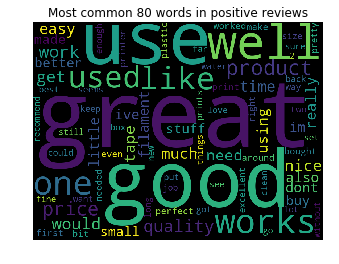

In [36]:
uniCloud(good, 'Most common 80 words in positive reviews')

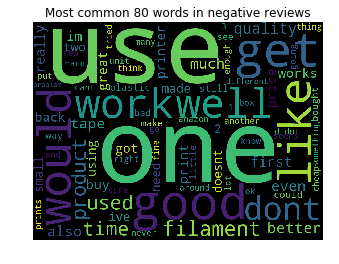

In [37]:
uniCloud(bad, 'Most common 80 words in negative reviews')

Compare the results from positive and negative reviews, it is clear that a few common unigrams are the same in both groups. This may influence the results. Try to build bag-of-word with a combination of unigram and bigram might help.

### 3.2 Unigram & Bigram WordCloud

In [38]:
def mixCloud(df, name):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    stop_words = set(stopwords.words('english'))
    
    # counts for unigrams
    for d in df['reviewText']:
        r = ''.join([c for c in d.lower() if not c in punctuation])
        tokens = nltk.wordpunct_tokenize(r)
        finder = BigramCollocationFinder.from_words(tokens)
        bigram_measures = nltk.collocations.BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.raw_freq)
        sort = sorted(bigram for bigram, score in scored)  
        for c1, c2 in sort:
            if c1 in stop_words and c2 in stop_words:
                continue            
            elif c1 not in stop_words and c2 not in stop_words:
                key = ' '.join([c1, c2])
            else:
                key = c1 if c2 in stop_words else c2
            wordCount[key] += 1        

    # Remove Stop words and choose the first 2000 most common words
    stop_words = set(stopwords.words('english'))
    counts = [(w, wordCount[w]) for w in wordCount if w not in stop_words]
    words = dict(counts)
    
    cloud = wordcloud.WordCloud(max_words=100, width=800, height=600, margin=1, collocations=False)
    cloud.generate_from_frequencies(words)
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(name) 
    plt.show()
    return pd.DataFrame(counts, columns=['word', 'counts']).sort_values(['counts'], ascending=False)


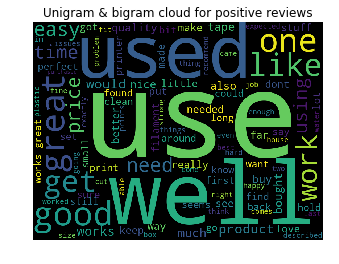

In [39]:
goodSorted = mixCloud(good, 'Unigram & bigram cloud for positive reviews')

In [40]:
pd.set_option('display.max_rows', 20)
goodSorted.reset_index(drop=True)[110:120]

,word,counts
110,place,979
111,end,978
112,pla,977
113,problems,977
114,case,973
115,something,965
116,read,957
117,new,956
118,home,955
119,looking,944


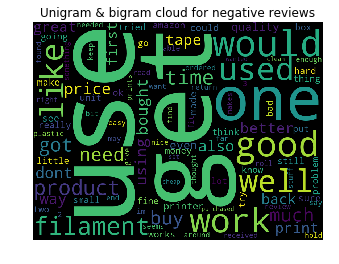

In [41]:
badSorted = mixCloud(bad, 'Unigram & bigram cloud for negative reviews')

In [42]:
badSorted.reset_index(drop=True)[:10]

,word,counts
0,use,1659
1,get,1425
2,one,1252
3,would,1068
4,good,1010
5,work,930
6,like,843
7,used,807
8,well,771
9,filament,708


Although the top of the most common still dominated by unigrams, actually make sense, there are additional bigrams that have been added in to the counts. But we also added more dimensions than just using unigram. Therefore, we need to be careful when selecting models.

### 3.3 TF-IDF score and Dimensionality reduction
TF-IDF transformation

In [46]:
def prepro(texts):
    '''
    Input: List/Series of raw review text
    Return: List of review texts without punctuation and stop-words.
            Bigrams are linked together without empty space
    '''

    # remove stop words
    grams = []
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    for d in texts:
        r = ''.join([c for c in d.lower() if not c in punctuation])
        tokens = nltk.wordpunct_tokenize(r)
        finder = BigramCollocationFinder.from_words(tokens)
        bigram_measures = nltk.collocations.BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.raw_freq)
        sort = sorted(bigram for bigram, score in scored)  
        temp = []
        for c1, c2 in sort:
            if c1 in stop_words and c2 in stop_words:
                continue            
            elif c1 not in stop_words and c2 not in stop_words:
                key = ''.join([c1, c2])
            else:
                key = c1 if c2 in stop_words else c2

            # finally filter stop_words again
            if key not in stop_words:
                temp.append(key)
        grams.append(' '.join(temp))
        
    return grams

In [47]:
gramsTrain = prepro(reviewTrain['reviewText'])
gramsTest = prepro(reviewTest['reviewText'])

In [48]:
gramsTrain[0]

'designed connectrange designedused ducting fanducting kitchen hoodventilation kitchen rangehood connect roof used ventilationfan worked'

#### Transformation

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
vectorizer = TfidfVectorizer()

In [51]:
tfidfTrain = vectorizer.fit_transform(gramsTrain)

In [52]:
tfidfTest = vectorizer.transform(gramsTest)

In [53]:
features = vectorizer.get_feature_names()

#### Sanity check for the transformed result

In [54]:
gramsTrain[0]

'designed connectrange designedused ducting fanducting kitchen hoodventilation kitchen rangehood connect roof used ventilationfan worked'

In [56]:
print('The dimension of features:', len(vectorizer.get_feature_names())) 
print('The dimension of a transformed text:', len(tfidfTrain[0].toarray()[0].tolist()))

The dimension of features: 243685
The dimension of a transformed text: 243685


In [57]:
sample = tfidfTrain[0].toarray()[0].tolist()
check = pd.DataFrame(zip(vectorizer.get_feature_names(), sample), columns=['gram', "score"])

In [58]:
check = check.sort_values(['score'], ascending=False)

In [59]:
# This setting may cause duplicate rows, be careful
pd.set_option('display.max_rows', 20) 
check.head()

,gram,score
115185,kitchen,0.380616
49834,connectrange,0.323587
77843,fanducting,0.323587
59430,designedused,0.323587
103234,hoodventilation,0.323587


TF-IDF really gives a better feature transformation.
But we need to be careful when dealing with high dimensional data.

### 3.4 Latent Semantic Analysis (LSA)

In [60]:
from sklearn.decomposition import TruncatedSVD

In [62]:
svd = TruncatedSVD(100)

For high dimensionality, needs more time to train the model

In [64]:
svdTrain = svd.fit_transform(tfidfTrain)

In [124]:
svdTest = svd.transform(tfidfTest)

In [65]:
svdTrain.shape

(38535, 100)

#### Sanity check for the dimensionality reduction result

In [66]:
comp = svd.components_[0]

# Sort the weights in the first component, and get the indeces
indeces = np.argsort(comp).tolist()
indeces.reverse()

# Check the features with the top 10 highest weights for the first component
terms = [features[i] for i in indeces[:10]]    
weights = [comp[i] for i in indeces[:10]] 

pd.DataFrame(zip(terms, weights), columns=['term', 'weights'])

,term,weights
0,worksgreat,0.911355
1,described,0.246945
2,works,0.167578
3,advertised,0.116632
4,great,0.101317
5,good,0.079566
6,expected,0.076767
7,greatproduct,0.065090
8,product,0.063105
9,exactly,0.055272


These features make more sense and should be more predictive.

## 4. Train Models

### 4.1 Naive Bayes 

In [146]:
from sklearn.naive_bayes import MultinomialNB

In [147]:
labelTrain = [1 if y > 4 else 0 for y in reviewTrain['rating']]
labelTest = [1 if y > 4 else 0 for y in reviewTest['rating']]

In [148]:
NB = MultinomialNB()
NB.fit(tfidfTrain, labelTrain)
predTrain = NB.predict(tfidfTrain)
predTest = NB.predict(tfidfTest)

In [149]:
print('The number of reviews predicted to be positive: ', sum(predTest))
print('The number of reviews predicted to be negative: ', len(reviewTest) - sum(predTest)) 

The number of reviews predicted to be positive:  19191
The number of reviews predicted to be negative:  67


In [151]:
print('The Balanced Error Rate: ', BER(predTest, labelTest))
print('The accuracy of Naive Bayes: ', accuracy(predTest, labelTest))

The Balanced Error Rate:  0.4937005904637234
The accuracy of Naive Bayes:  0.7383425070100738


Seems simply predict all to be positive. Did not catch much negative reviews, which means have a high false positive rate. However, FP is risky.

### 4.2 Logistic Regression with larger weights on negative sample

Assign larger weights to negative samples would encourage the logistic regressor to optimize for False Positive Rate. 

In [112]:
from sklearn import linear_model
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

#### Measures for LR: F1 score, BER, Accuracy

In [128]:
def F1_BER(weights, Xtrain, ytrain, Xtest, ytest):
    mod = linear_model.LogisticRegression(C=1, solver='lbfgs')
    mod.fit(Xtrain, ytrain, sample_weight=weights)
    scores = mod.decision_function(Xtest)
    scoreslabels = list(zip(scores, ytest))
    scoreslabels.sort(reverse=True)
    sortedlabels = [x[1] for x in scoreslabels]
    pred = mod.predict(Xtest)
    retrieved = sum(pred)
    relevant = sum(ytest)
    intersection = sum([y and p for y, p in zip(ytest, pred)])
    # precision
    precision = intersection / retrieved
    # recall
    recall = intersection / relevant
    F_1 = 2 * precision * recall / (precision + recall)
    
    # Balance Error Rate
    ber = BER(pred, ytest)
    
    # Accuracy
    accur = accuracy(pred, ytest)
    
    #F_10 = (1 + 10**2) * precision * recall / ((10**2) * (precision + recall))
    return [F_1, ber, accur]

In [131]:
F_1 = []
ber = []
accur = []
x = []
for i in range(1, 10):
    weights = [1 if y else i for y in labelTrain]
    x.append(i)
    res = F1_BER(weights, tfidfTrain, labelTrain, tfidfTest, labelTest)
    F_1.append(res[0])
    ber.append(res[1])
    accur.append(res[2])

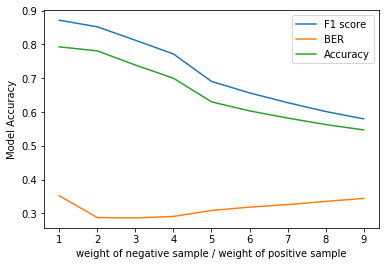

In [132]:
plt.figure()
plt.plot(x, F_1, label = 'F1 score')
plt.plot(x, ber, label = 'BER')
plt.plot(x, accur, label = 'Accuracy')
plt.xlabel('weight of negative sample / weight of positive sample')
plt.ylabel('Model Accuracy')
plt.legend()
plt.show()

### 4.3 Logistic Regression with larger weights and SVD feature

In [137]:
F_1 = []
ber = []
accur = []
x = []
for i in range(1, 10):
    weights = [1 if y else i for y in labelTrain]
    x.append(i)
    res = F1_BER(weights, svdTrain, labelTrain, svdTest, labelTest)
    F_1.append(res[0])
    ber.append(res[1])
    accur.append(res[2])

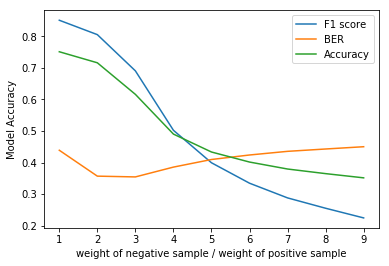

In [138]:
plt.figure()
plt.plot(x, F_1, label = 'F1 score')
plt.plot(x, ber, label = 'BER')
plt.plot(x, accur, label = 'Accuracy')
plt.xlabel('weight of negative sample / weight of positive sample')
plt.ylabel('Model Accuracy')
plt.legend()
plt.show()

Using SVD will reduce the overall perfermance of Logistic Regression, which makes sense. But will decrease the running time.

### 4.4 Random Forest

In [140]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
RF = RandomForestClassifier(n_estimators=1000, random_state=0)
RF.fit(svdTrain, labelTrain) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [143]:
pred = RF.predict(svdTest)

In [144]:
BER(pred, labelTest)

0.3971471941314948

In [145]:
accuracy(pred, labelTest)

0.775885346349569

## 5. Conclusion from Results

It takes much more time to train a RF model. Therefore, I don't try to tunning the parameter. But we can also see from the result that, Logistc Regression works well on this problem.

But comparing to the baseline model, it seems that latent factor model actuall beat all the other 3 machine learning models. That's probably why recommender system can works pretty well.

The most hard problem to deal with is actually the imbalanced data. Naive Bayes, Random Forest not work well in this case. Therefore, when dealing with imbalanced data, we need to be careful when choosing a machine learning model.